In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mahotas as mh
import json

In [3]:
import cactas as C

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'

In [5]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [6]:
with open(DATAPATH+'../ESUS_stroke_side.csv', 'r') as f:
    stroke_sides = f.read().replace('ESUS ','').split('\n')

STROKE_SIDES = {}
    
for l in stroke_sides[1:]:
    l_s = l.split(',')
    
    if len(l_s) != 5:
        continue
    
    id_ = l_s[0]
    age = l_s[1]
    sex = l_s[2]
    race = l_s[3]
    side = l_s[4]
    STROKE_SIDES[id_] = side

In [7]:
images, labels = C.Util.load(DATAPATH)

In [8]:
for key, val in image_data.items():
    stroke_side = STROKE_SIDES[key]
    #print('file name', key)
    #print('Stroke side', stroke_side)

In [9]:
# normalize grayscale to 0..1
images, labels = C.Util.normalize(images, labels)

# for each scan
symp_i_patches = []
symp_l_patches = []
asymp_i_patches = []
asymp_l_patches = []

P=28

In [10]:
images.shape

(766, 512, 512, 1)

In [11]:
labels.shape

(766, 512, 512, 1)

In [12]:
# Crop

In [13]:
cropped_label = []
cropped_image = []

In [14]:
# for each scan
symp_i_patches = []
symp_l_patches = []
asymp_i_patches = []
asymp_l_patches = []

In [15]:
from skimage.filters import threshold_otsu

In [16]:
data = {}
count = 0
ids = []

In [17]:
datas = {}
counts = 0

In [18]:
print(list(image_data.keys())[list(image_data.values()).index(36)]) 

7


In [19]:
image_data.items()

dict_items([('2', 0), ('5', 10), ('6', 17), ('7', 36), ('9', 54), ('10', 64), ('12', 77), ('13', 87), ('14', 114), ('15', 121), ('16', 126), ('17', 149), ('18', 169), ('21', 190), ('22', 201), ('23', 221), ('24', 242), ('25', 246), ('26', 265), ('27', 276), ('29', 282), ('31', 305), ('32', 328), ('33', 335), ('35', 343), ('36', 346), ('39', 351), ('40', 357), ('41', 362), ('45', 365), ('46', 374), ('47', 376), ('48', 384), ('49', 407), ('50', 423), ('51', 432), ('52', 470), ('53', 474), ('57', 479), ('61', 491), ('62', 499), ('63', 509), ('64', 518), ('66', 522), ('69', 527), ('71', 532), ('72', 545), ('73', 560), ('75', 568), ('77', 579), ('79', 586), ('82', 596), ('83', 609), ('84', 619), ('86', 625), ('87', 631), ('88', 643), ('90', 657), ('91', 675), ('92', 684), ('93', 725), ('94', 729), ('96', 735), ('97', 752)])

In [20]:
for f in os.listdir(DATAPATH):
    if f.endswith('.img.nrrd'):
        current_id = f.split('.')[0]
        ids += [int(current_id)]
        ids = sorted(ids)

print(ids)

[2, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 35, 36, 39, 40, 41, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57, 61, 62, 63, 64, 66, 69, 71, 72, 73, 75, 77, 79, 82, 83, 84, 86, 87, 88, 90, 91, 92, 93, 94, 96, 97]


In [32]:
symp_data = {}  
asymp_data = {}
patient_id = ''  
count = 0
counts = 0

for i in range(labels.shape[0]):
    thresh = threshold_otsu(labels[i])
    binary = labels[i] > (0.5 * thresh)
    relabel, obj = mh.label(binary)

    #print(f"Number of objects in image {i}: {obj}")

    for j in range(1, relabel.max()+1):
        single_label = np.zeros((relabel.shape), relabel.dtype)
        single_label[relabel == j] = 1

        bbox = mh.bbox(single_label)
        #print(bbox)

        location = ''
        if (512-bbox[0] < 256):
            location = 'L' # patient view
        else:
            location = 'R' # patient view


        increase_x = 10
        increase_y = 10
        increase_z = 0
        target_size = P


        if target_size:
            widthY = bbox[1]-bbox[0]
            widthX = bbox[3]-bbox[2]
            #print(widthY)
            #print(widthX)

            increase_x = (target_size - widthX) // 2
            increase_y = (target_size - widthY) // 2

            #print(bbox)
            #print(widthY, widthX, increase_x, increase_y)

            bufferY = 0
            if (bbox[0]-increase_y + bbox[1]+increase_y) != target_size:
                bufferY = 1

            bufferX = 0
            if (bbox[2]-increase_x + bbox[3]+increase_x) != target_size:
                bufferX = 1

        # crop label and image according to bbox but make it a little larger
        label_cropped = labels[i][bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                               bbox[2]-increase_x:bbox[3]+increase_x+bufferX]
        image_cropped = images[i][bbox[0]-increase_y:bbox[1]+increase_y+bufferY,
                               bbox[2]-increase_x:bbox[3]+increase_x+bufferX]
        

        #cropped_label.append(label_cropped)
        #cropped_image.append(image_cropped)
        
        
        for k, v in image_data.items():
            if i >= v:
                patient_id = k
            else:
                break


        if location == stroke_side:
            if patient_id in symp_data:
                #symp_data[patient_id] = {'symp': [count], 'asymp': []}
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(label_cropped)
                count += 1
            else:
                symp_data[patient_id] = count
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(label_cropped)
                count += 1
        else:
            if patient_id in asymp_data:
                #asymp_data[patient_id] = {'symp': [], 'asymp': [counts]}
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(label_cropped)
                counts += 1
            else:
                asymp_data[patient_id] = counts
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(label_cropped)
                counts += 1


        '''
        if patient_id in patient_data:
            if location == stroke_side:
                patient_data[patient_id]['symp'].append(count)
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(label_cropped)
                count += 1
            else:
                patient_data[patient_id]['asymp'].append(counts)
                asymp_i_patches.append(image_cropped)
                asymp_l_patches.append(label_cropped)
                counts += 1
        else:
            if location == stroke_side:
                patient_data[patient_id] = {'symp': [count], 'asymp': []}
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(label_cropped)
                count += 1
            else:
                patient_data[patient_id] = {'symp': [], 'asymp': [counts]}
                asymp_i_patches.append(image_cropped)
                asymp_l_patches.append(label_cropped)
                counts += 1
        '''

In [33]:
symp_data

{'2': 0,
 '5': 4,
 '6': 12,
 '7': 27,
 '9': 45,
 '10': 67,
 '12': 81,
 '13': 89,
 '14': 107,
 '15': 113,
 '16': 118,
 '18': 137,
 '21': 157,
 '22': 168,
 '23': 176,
 '24': 200,
 '25': 203,
 '26': 220,
 '29': 233,
 '31': 245,
 '32': 271,
 '33': 281,
 '35': 285,
 '36': 287,
 '39': 292,
 '40': 303,
 '41': 308,
 '45': 311,
 '47': 313,
 '48': 315,
 '49': 346,
 '50': 371,
 '51': 381,
 '52': 398,
 '53': 401,
 '57': 406,
 '61': 412,
 '62': 419,
 '63': 428,
 '64': 432,
 '69': 436,
 '71': 440,
 '72': 455,
 '73': 461,
 '75': 470,
 '77': 477,
 '79': 487,
 '82': 503,
 '83': 520,
 '84': 527,
 '86': 533,
 '87': 538,
 '88': 558,
 '90': 577,
 '91': 607,
 '92': 611,
 '94': 676,
 '96': 682,
 '97': 689}

In [34]:
asymp_data

{'2': 0,
 '6': 10,
 '7': 42,
 '12': 53,
 '13': 66,
 '14': 89,
 '16': 98,
 '17': 119,
 '18': 161,
 '21': 188,
 '22': 212,
 '23': 245,
 '24': 256,
 '25': 259,
 '26': 281,
 '27': 294,
 '29': 300,
 '31': 326,
 '33': 352,
 '35': 359,
 '36': 360,
 '39': 363,
 '40': 367,
 '45': 372,
 '46': 384,
 '47': 386,
 '49': 397,
 '50': 410,
 '51': 435,
 '52': 477,
 '57': 478,
 '61': 486,
 '62': 491,
 '63': 501,
 '66': 511,
 '69': 516,
 '71': 523,
 '72': 538,
 '75': 553,
 '77': 561,
 '79': 569,
 '82': 581,
 '83': 592,
 '84': 595,
 '86': 598,
 '87': 600,
 '88': 607,
 '90': 612,
 '91': 623,
 '92': 632,
 '93': 693,
 '96': 697,
 '97': 710}

In [36]:
#with open("symp_data.json", "w") as fp:
#    json.dump(symp_data, fp) 

In [37]:
#with open("asymp_data.json", "w") as fp:
#    json.dump(asymp_data, fp) 

In [23]:
len(symp_i_patches), len(symp_l_patches) #704

(704, 704)

In [24]:
len(asymp_i_patches), len(asymp_l_patches) # 713

(713, 713)

In [25]:
len(symp_i_patches) + len(asymp_i_patches)

1417

In [26]:
symp_i_patches[0].shape

(29, 29, 1)

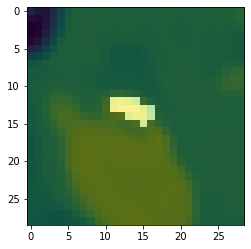

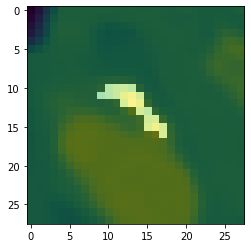

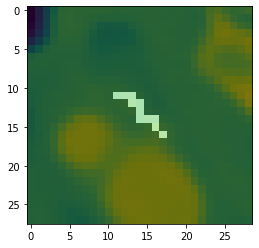

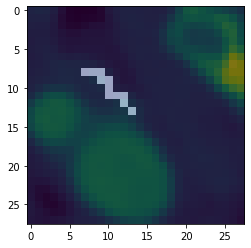

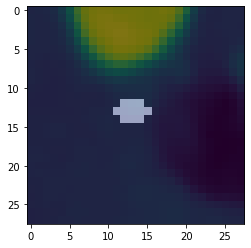

In [21]:
for i in range(5): # len(symp_i_patches)
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    #ax1.imshow(symp_i_patches[i], cmap='gray')
    #ax2.imshow(symp_l_patches[i])
    plt.imshow(symp_i_patches[i])
    plt.imshow(symp_l_patches[i], cmap='gray', alpha=0.5)
    plt.show()

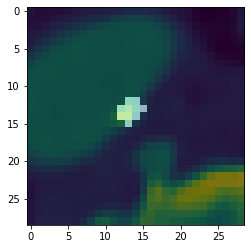

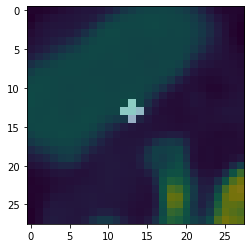

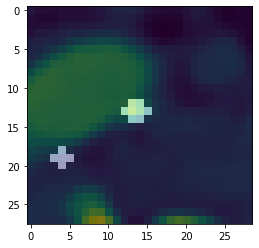

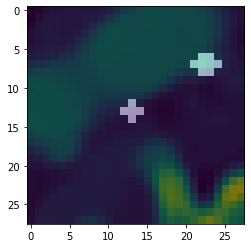

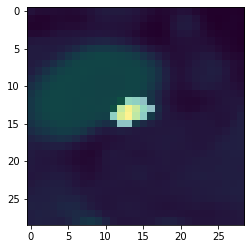

In [22]:
for i in range(5):  # len(asymp_i_patches)
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    #ax1.imshow(asymp_i_patches[i], cmap='gray')
    #ax2.imshow(asymp_l_patches[i])
    plt.imshow(asymp_i_patches[i])
    plt.imshow(asymp_l_patches[i], cmap='gray', alpha=0.5)
    plt.show()

In [23]:
def list_to_array(l):
    count = len(l)

    d_y = l[0].shape[0]
    d_x = l[0].shape[1]

    out = np.zeros((count, d_y, d_x, 1), dtype=l[0].dtype)

    for i in range(count):
        c_d_y = min(d_y, l[i].shape[0])
        c_d_x = min(d_x, l[i].shape[1])
        
        #print(out[i, 0:c_d_y,0:c_d_x].shape)
        #print(l[i][0:c_d_y,0:c_d_x].shape)
        out[i, 0:c_d_y,0:c_d_x] = l[i][0:c_d_y,0:c_d_x]

    return out

In [24]:
symp_i_patches_a = list_to_array(symp_i_patches)

In [25]:
symp_i_patches_a.shape

(704, 29, 29, 1)

In [26]:
asymp_i_patches_a = list_to_array(asymp_i_patches)

In [27]:
asymp_i_patches_a.shape

(713, 29, 29, 1)

In [28]:
len(symp_i_patches_a)

704

In [29]:
len(asymp_i_patches_a)

713

In [30]:
symp_l_patches_a = list_to_array(symp_l_patches)

In [31]:
symp_l_patches_a.shape

(704, 29, 29, 1)

In [32]:
asymp_l_patches_a = list_to_array(asymp_l_patches)

In [33]:
asymp_l_patches_a.shape

(713, 29, 29, 1)

In [34]:
len(symp_l_patches_a)

704

In [35]:
len(asymp_l_patches_a)

713

In [36]:
symp_count = len(symp_i_patches_a)
symp_images_npy = np.zeros((symp_count, P,P,1), dtype=symp_i_patches_a[0].dtype)

for i,img in enumerate(symp_i_patches_a):
    symp_images_npy[i] = symp_i_patches_a[i,0:P,0:P]

In [37]:
asymp_count = len(asymp_i_patches_a)
asymp_images_npy = np.zeros((asymp_count, P,P,1), dtype=asymp_i_patches_a[0].dtype)

for i,img in enumerate(asymp_i_patches_a):
    asymp_images_npy[i] = asymp_i_patches_a[i,0:P,0:P]

In [38]:
symp_images_npy.shape

(704, 28, 28, 1)

In [39]:
asymp_images_npy.shape

(713, 28, 28, 1)

In [34]:
#np.save(os.path.join(DATAPATH, 'asymp_cropped_no_norm.npy'), asymp_images_npy)
#np.save(os.path.join(DATAPATH, 'symp_cropped_no_norm.npy'), symp_images_npy)

In [40]:
symp_count_a = len(symp_l_patches_a)
symp_labels_npy = np.zeros((symp_count_a, P,P,1), dtype=symp_l_patches_a[0].dtype)

for i,img in enumerate(symp_l_patches_a):
    symp_labels_npy[i] = symp_l_patches_a[i,0:P,0:P]

In [41]:
asymp_count_a = len(asymp_l_patches_a)
asymp_labels_npy = np.zeros((asymp_count_a, P,P,1), dtype=asymp_l_patches_a[0].dtype)

for i,img in enumerate(asymp_l_patches_a):
    asymp_labels_npy[i] = asymp_l_patches_a[i,0:P,0:P]

In [42]:
symp_labels_npy.shape

(704, 28, 28, 1)

In [43]:
asymp_labels_npy.shape

(713, 28, 28, 1)

In [44]:
#np.save(os.path.join(DATAPATH, 'asymp_cropped_labels_no_norm.npy'), asymp_labels_npy)
#np.save(os.path.join(DATAPATH, 'symp_cropped_labels_no_norm.npy'), symp_labels_npy)

In [35]:
for z in range(symp_images_npy.shape[0]):
    symp_images_npy[z] = (symp_images_npy[z] - symp_images_npy[z].min()) / (symp_images_npy[z].max() - symp_images_npy[z].min())

In [36]:
for z in range(asymp_images_npy.shape[0]):
    asymp_images_npy[z] = (asymp_images_npy[z] - asymp_images_npy[z].min()) / (asymp_images_npy[z].max() - asymp_images_npy[z].min())

In [37]:
#np.save(os.path.join(DATAPATH, 'asymp_cropped.npy'), asymp_images_npy)
#np.save(os.path.join(DATAPATH, 'symp_cropped.npy'), symp_images_npy)

In [45]:
for z in range(symp_labels_npy.shape[0]):
    symp_labels_npy[z] = (symp_labels_npy[z] - symp_labels_npy[z].min()) / (symp_labels_npy[z].max() - symp_labels_npy[z].min())

In [46]:
for z in range(asymp_labels_npy.shape[0]):
    asymp_labels_npy[z] = (asymp_labels_npy[z] - asymp_labels_npy[z].min()) / (asymp_labels_npy[z].max() - asymp_labels_npy[z].min())

In [48]:
#np.save(os.path.join(DATAPATH, 'asymp_labels_cropped.npy'), asymp_labels_npy)
#np.save(os.path.join(DATAPATH, 'symp_labels_cropped.npy'), symp_labels_npy)

In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

In [39]:
labels_test = np.array([0]*len(asymp_l_patches) + [1]*len(symp_l_patches))

In [40]:
images_test = np.concatenate((symp_images_npy, asymp_images_npy))

In [41]:
labels_test.shape

(1417,)

In [42]:
images_test.shape

(1417, 28, 28, 1)

In [43]:
X, y = shuffle(images_test, labels_test, random_state=0)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

In [45]:
rf = RandomForestClassifier(n_estimators=100)

In [46]:
X_train_raveled = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

In [47]:
X_val_raveled = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

In [48]:
fitted = rf.fit(X_train_raveled, y_train)

In [49]:
y_pred = rf.predict(X_val_raveled)

In [50]:
sklearn.metrics.accuracy_score(y_val, y_pred)

0.8415492957746479

In [51]:
sklearn.metrics.f1_score(y_val, y_pred)

0.8363636363636364

In [52]:
y_pred

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1])

In [53]:
y_val

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1])